In [2]:
!pip install torch torchvision matplotlib tensorboard

In [1]:
"""
Introduction
In this notebook, we’ll be training a variant of LeNet-5 against the Fashion-MNIST dataset.
Fashion-MNIST is a set of image tiles depicting various garments,
with ten class labels indicating the type of garment depicted.
"""

# Pytorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Pytorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

/Users/kantip/anaconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


26422272it [00:14, 1881042.34it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



29696it [00:00, 144724.95it/s]                          


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



4422656it [00:02, 1812999.33it/s]                             


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



6144it [00:00, 12025106.76it/s]         

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



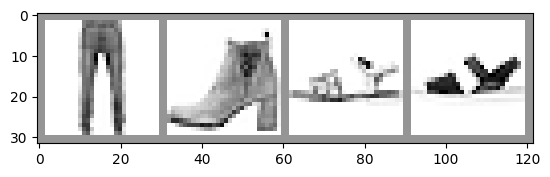

In [2]:
# Showing Images in TensorBoard
# Gather datasets and prepare them for consumption
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Store separate traning and validating splits in ./data
training_set = torchvision.datasets.FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=transform
)

validation_set = torchvision.datasets.FashionMNIST(
    root='./data',
    download=True,
    train=False,
    transform=transform
)

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [7]:
"""
Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data.
Below, we use the add_image() call on SummaryWriter to log the image for consumption by TensorBoard,
and we also call flush() to make sure it’s written to disk right away.
"""

# Default log_dir argument is "runs" - but it's goood to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter("runs/fashion_mnist_experiment_1")

# Write image data to TensorBoard log dir
writer.add_image(F"Four Fashion-MNIST Images", img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

"""
If you start TensorBoard at the command line and open it in a new browser tab
(usually at localhost:6006),
you should see the image grid under the IMAGES tab.
"""

'\nIf you start TensorBoard at the command line and open it in a new browser tab\n(usually at localhost:6006),\nyou should see the image grid under the IMAGES tab.\n'

***Graphing Scalars to Visualize Training***
* TensorBoard is useful for tracking the progress and efficacy of your training. Below, we’ll run a training loop, track some metrics, and save the data for TensorBoard’s consumption.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)

In [8]:
# Now let's train a single epoch, and evaluate the training vs validation set losses every 1000 batches:
print(f"--- Number of validation loader : {len(validation_loader)}")
for epoch in range(1):
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        #basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print("Batch {}".format(i+1))
            # Check against the validation set
            running_vloss = 0.0

            # net.train(False) # Don't need to track gradients for validation
            net.eval()
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars("Training vs. Validation Loss",
                               {"Training": avg_loss, "Validation": avg_vloss},
                               epoch * len(training_loader) + i)

            print(f"train loss: {avg_loss}, val loss: {avg_vloss}")
            running_loss=0
print("Finished Training")

writer.flush()

--- Number of validation loader : 2500
Batch 1000
train loss: 0.3327255552636925, val loss: 0.34545030004991567
Batch 2000
train loss: 0.33344277851693915, val loss: 0.35100915413549955
Batch 3000
train loss: 0.3162693905665219, val loss: 0.37156633878568135
Batch 4000
train loss: 0.3206511352878861, val loss: 0.35611339125766245
Batch 5000
train loss: 0.3147794957934093, val loss: 0.3413432437701238
Batch 6000
train loss: 0.35560640785598663, val loss: 0.33323818389862425
Batch 7000
train loss: 0.312713975404331, val loss: 0.3452357994686972
Batch 8000
train loss: 0.29010669457487165, val loss: 0.35976056240680626
Batch 9000
train loss: 0.31463613757066194, val loss: 0.35371846483540703
Batch 10000
train loss: 0.33633319627918534, val loss: 0.3365860953689109
Batch 11000
train loss: 0.3233412541206053, val loss: 0.3498185844729931
Batch 12000
train loss: 0.3010631700804024, val loss: 0.3274451821153165
Batch 13000
train loss: 0.3035205461163423, val loss: 0.3350903860272063
Batch 1400

***Visualizin Your Model***
* TensorBoard can also be used to examine the data flow within your model. To do this, call the add_graph() method with a model and sample input. When you open

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through, your model
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

# When you switch over to TensorBoard, you should see a GRAPHS tab.
# Double-click the “NET” node to see the layers and data flow within your model.

***Visualizing Your Dataset with Embeddings***
* The 28-by-28 image tiles we’re using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The add_embedding() method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The add_embedding() method does this automatically by projecting to the three dimensions with highest variance.

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()